In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
raw_clinical_path = 'data/raw/PatientClinicalData.xlsx'
glossary_path = 'data/clean/clinical/glossary.csv'
samples_path = 'data/clean/samples_list.csv'
# output
clean_clinical_path = 'data/clean/clinical/data.csv'

Clinical data did not require a separate extraction step, thus I will clean the spreadsheet and explore the data in a single notebook (this one).

# Data Extraction

In [3]:
clinical_spreadsheets = read_excel(raw_clinical_path, sheet_name=None)

In [4]:
clinical_spreadsheets.keys()

odict_keys(['Clinical MetaData', 'Parameter Glossary'])

## Glossary

In [5]:
clinical_glossary = clinical_spreadsheets['Parameter Glossary']

In [6]:
clinical_glossary.head()

,PatientID,Randomisd study ID
0,AdmissionDate,The date when the patient is admitted to the s...
1,Birthday,Date of birth
2,Sex,Gender at birth
3,PrevTB,Past history of TB?
4,PrevTBForm,What form of TB was it in the past? (Note: yo...


In [7]:
len(clinical_glossary)

39

Perfect! Nice and computer readable format. Not much to see there.

The first raw was taken as a column name, I will mitigate it reloading the data with proper headers:

In [8]:
clinical_glossary.to_csv(glossary_path, index=False)
clinical_glossary = read_csv(glossary_path, names=['variable', 'description'])

In [9]:
clinical_glossary.head(n=2)

,variable,description
0,PatientID,Randomisd study ID
1,AdmissionDate,The date when the patient is admitted to the s...


And save the clean copy:

In [10]:
clinical_glossary.to_csv(glossary_path)

## Clinical data

In [11]:
clinical_data = clinical_spreadsheets['Clinical MetaData']

In [12]:
clinical_data

,PatientID,AdmissionDate,Birthday,Sex,PrevTB,...,SteroidsStarted,SteroidDate,SteroidType,Death,DateDeath
0,001.TMD,2015-02-06,1980-01-04,M,N,...,Y,2015-02-08,Prednisone,Alive,NaT
1,006.CM,2014-02-11,1966-05-05,M,Y,...,N,NaT,NaN,Alive,NaT
2,007.TMD,2015-02-16,1984-02-28,F,N,...,Y,2015-02-16,Dexamethasone,Alive,NaT
3,011.TMR,2015-02-17,1988-03-01,F,Y,...,N,NaT,NaN,Alive,NaT
4,012.BM,2015-02-19,1961-01-09,M,N,...,N,NaT,NaN,Alive,NaT
...,...,...,...,...,...,...,...,...,...,...,...
93,256.CM,2015-11-09,1964-03-28,M,Y,...,Y,2015-11-10,Prednisone,Alive,NaT
94,261.CM,2015-11-17,1970-02-05,F,Y,...,N,NaT,NaN,Death,2015-11-27
95,158.TMD,2015-08-19,1986-06-05,M,N,...,N,NaT,NaN,Alive,NaT
96,167.TMR,2015-08-25,1969-06-06,M,Y,...,Y,2015-08-31,Dexamethasone,Alive,NaT


In [13]:
from helpers.presentation import show_list, compare_sets

### Do we have description for each column?

In [14]:
compare_sets(clinical_data.columns, clinical_glossary.variable)

Okay, so there is a typo the glossary, I will fix that so to make data merges easier in the future:

In [15]:
clinical_glossary.variable = clinical_glossary.variable.replace({'OnTBTReat': 'OnTBTreat'})
clinical_glossary.to_csv(glossary_path, index=False)

Should work now:

In [16]:
assert set(clinical_data.columns) == set(clinical_glossary.variable)

# Data exploration and reformatting

I do not see an atomic column with condition; for simplicity I will create it now:

In [17]:
clinical_data['condition'] = clinical_data.PatientID.str.split('.').str[1]

In [18]:
clinical_data['condition'].value_counts()

CM     28
HC     25
TMD    19
TMR    10
VM      8
TMS     6
BM      2
Name: condition, dtype: int64

## Getting to know the variables

There are only ~~37~~ 39 variables so I will explore each of these, one-by-one.

The descriptions from glossary will come in handy:

In [19]:
glossary = clinical_glossary.set_index('variable').description

### 0. PatientID

We should have data for all patients:

In [20]:
samples_list = read_csv(samples_path)

In [21]:
compare_sets(samples_list.sample_id, clinical_data.PatientID)

Great!

In [22]:
len(samples_list.sample_id)

95

### 1. The admission date

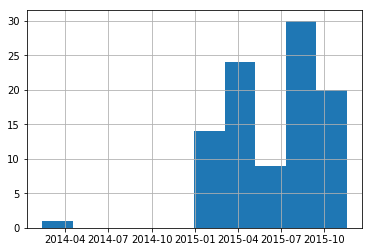

In [23]:
clinical_data.AdmissionDate.hist();

In [24]:
assert not clinical_data.AdmissionDate.isnull().any()

### 2. The date of birth

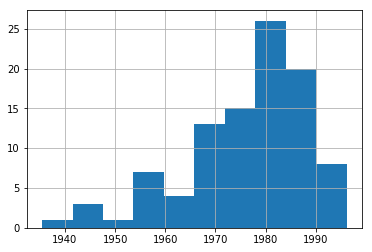

In [25]:
clinical_data.Birthday.hist();

In [26]:
clinical_data.Birthday.describe()

count                      98
unique                     98
top       1971-03-16 00:00:00
freq                        1
first     1935-06-25 00:00:00
last      1996-02-10 00:00:00
Name: Birthday, dtype: object

The value ranges are plausible (as the has data from ~2015, the oldest participant had about 80 years), no suspicious duplicates.

### 3. History of TB

PrevTB is expected to be a binary column:

In [27]:
set(clinical_data.PrevTB)

{'N', 'Unknown', 'Y', nan}

In [28]:
clinical_data[~clinical_data.PrevTB.isin(['N', 'Y'])]

,PatientID,AdmissionDate,Birthday,Sex,PrevTB,...,SteroidDate,SteroidType,Death,DateDeath,condition
6,015.CM,2015-02-23,1980-09-15,F,NaN,...,NaT,NaN,Death,2015-05-04,CM
21,049.TMS,2015-03-17,1959-01-25,M,Unknown,...,2015-03-18,Dexamethasone,Death,2015-03-24,TMS
31,080.HC,2015-04-14,1935-06-25,F,Unknown,...,NaT,NaN,Alive,NaT,HC


I assume that the 'Unknown' and missing values convey the same information of the history of TB not being known.

In [29]:
from numpy import nan

In [30]:
def yes_no_unknown_to_binary(column):
    mapping = {'N': False, 'Y': True, 'Unknown': nan}
    assert not set(column) - {nan, *mapping.keys()}
    return column.replace(mapping)

In [31]:
clinical_data.PrevTB = yes_no_unknown_to_binary(clinical_data.PrevTB)

In [32]:
counts = clinical_data.PrevTB.fillna('Unknown').value_counts()
counts.to_frame()

,PrevTB
False,54
True,41
Unknown,3


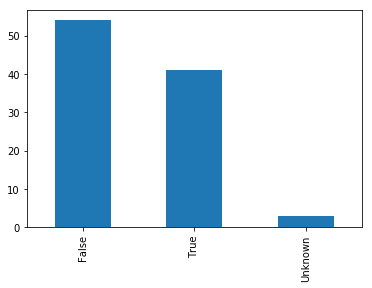

In [33]:
counts.plot(kind='bar');

In [34]:
patients_with_history_of_tb = clinical_data[clinical_data.PrevTB == True].PatientID

### 4. Form of previous TB

In [35]:
glossary['PrevTBForm']

'What form of TB was it in the past?  (Note: you can group any non-pulmonary as extrapulmonary for binary data)'

In [36]:
clinical_data['PrevTBForm'].value_counts().to_frame()

,PrevTBForm
Pulmonary,36
"Pulmonary, Pleural",1
"Pulmonary, Meningeal",1
"Pulmonary, TBM",1
Meningeal,1


This column does not satisfy the first normal form - I will add binary columns (as suggested in the description):

In [37]:
clinical_data['was_previous_tb_pulmonary'] = clinical_data.apply(lambda patient:
    # ignore patients with no history of TB (set the value to NaN):
    nan if not (patient.PrevTB == True) else
    'Pulmonary' in str(patient.PrevTBForm)
, axis=1)

Dr Rachel has confirmed that pleural does count as extrapulmonary:

In [38]:
clinical_data['was_previous_tb_extrapulmonary'] = clinical_data.apply(lambda patient:
    nan if not (patient.PrevTB == True) else
    any(
        term in str(patient.PrevTBForm)
        for term in ['TBM', 'Meningeal', 'Pleural']
    )
, axis=1)

I will not be creating a separate column for *meningeal* now (it would be strongly correlated with *extrapulmonary*); I do not think that the difference of the single additional observation (one *pleural* patient more the *extrapulmonary* cohort) would make a big impact.

In [39]:
clinical_data[['PrevTB', 'PrevTBForm', 'was_previous_tb_pulmonary', 'was_previous_tb_extrapulmonary']].head(n=8)

,PrevTB,PrevTBForm,was_previous_tb_pulmonary,was_previous_tb_extrapulmonary
0,False,NaN,NaN,NaN
1,True,Pulmonary,True,False
2,False,NaN,NaN,NaN
3,True,"Pulmonary, TBM",True,True
4,False,NaN,NaN,NaN
5,False,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,True,Pulmonary,True,False


#### Sanity check

If patient has a form of previous TB given, they should be marked as having history of TB:

In [40]:
patients_with_previous_tb_form_data = clinical_data[~clinical_data.PrevTBForm.isnull()].PatientID
assert not set(patients_with_previous_tb_form_data) - set(patients_with_history_of_tb)

And it is indeed the case. How many patients have known history but no subtype given?

In [41]:
compare_sets(patients_with_history_of_tb, patients_with_previous_tb_form_data)

Just one - that's very good!

### 5. Treatment for the previous TB

In [42]:
glossary['PrevTBTreat']

'Did the patient receive TB treatment in the past?'

In [43]:
clinical_data['PrevTBTreat'].value_counts()

Y          41
Unknown     2
N           1
Name: PrevTBTreat, dtype: int64

I will create an additional, binary column for the previous treatment, with a different encoding for missing values:

In [44]:
clinical_data['previous_tb_treatment'] = clinical_data.apply(lambda patient:
    nan if not (patient.PrevTB == True) else
    (
        nan if patient.PrevTBTreat == 'Unknown' else
        patient.PrevTBTreat == 'Y'
    )
, axis=1)

In [45]:
subset = clinical_data[['PatientID', 'PrevTB', 'PrevTBTreat', 'previous_tb_treatment']]
subset.head(n=2)

,PatientID,PrevTB,PrevTBTreat,previous_tb_treatment
0,001.TMD,False,NaN,NaN
1,006.CM,True,Y,True


In [46]:
subset.tail(40).head(8)

,PatientID,PrevTB,PrevTBTreat,previous_tb_treatment
58,148.HC,False,N,NaN
59,149.TMD,False,NaN,NaN
60,151.TMD,False,NaN,NaN
61,153.CM,True,Y,True
62,154.VM,True,Y,True
63,155.TMR,True,Y,True
64,156.VM,True,Y,True
65,165.VM,False,NaN,NaN


An example of the advantage of the new column is that `148.HC` (58th row) has `NaN` assigned because this patient has no history of TB. The original, `PrevTBTreat` column has 'N' value for this patient. This may be slightly suspicious, given that some other patients (e.g. `149.TMD`/59th row) who also have no history of TB have `NaN` in the original column.

#### Sanity check

In [47]:
patients_with_previous_tb_treatment = clinical_data[clinical_data.PrevTBTreat == 'Y'].PatientID
assert not set(patients_with_previous_tb_treatment) - set(patients_with_history_of_tb)

### 6. Grade of TBM

In [48]:
glossary['TBMGrade']

'TBM grade (severity) at the time of admission; Grade 3 is the worst and Grade 1 is the least severe'

In [49]:
clinical_data['TBMGrade'].value_counts()

1    63
2    33
3     2
Name: TBMGrade, dtype: int64

Already in numeric format, that's great.

**Note:** only two patients with grade three!

### 7. HIV Result

In [50]:
glossary['HIVResult']

'Does the patient have HIV?'

In [51]:
clinical_data['HIVResult'].value_counts()

Positive    82
Negative    16
Name: HIVResult, dtype: int64

### 8. CD4

In [52]:
glossary['CD4']

'Number of CD4 T-cells per ml of blood'

Distribution is skewed towards zero:

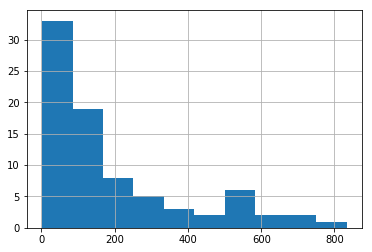

In [53]:
clinical_data['CD4'].hist();

In [54]:
clinical_data['CD4'].describe()

count     81.000000
mean     189.827160
std      200.799576
min        2.000000
25%       44.000000
50%      111.000000
75%      262.000000
max      833.000000
Name: CD4, dtype: float64

And there are data for 78/95 patients.

It seems that that CD4 count is related to HIV/AIDS. A [US governmental site](https://www.hiv.va.gov/patient/diagnosis/labs-CD4-count.asp) states that 200 is a threshold for AIDS diagnosis but they do not give units; I am going to find a more accurate and reliable source and also read [PMC3729334](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3729334/) to understand the context a better at some time.

### 9. Is patient on antiretroviral drug(s)?

In [55]:
glossary['ARV']

'Is the patient currently on antiretroviral for HIV?'

In [56]:
clinical_data['ARV'].value_counts()

N    43
Y    39
Name: ARV, dtype: int64

No need to reformat to another binary format as there are no "Unknown" values.

Data 79 patients, similar to the 78 above.
Is there a pattern in the missing data - e.g. are these only missing in healthy controls?

In [57]:
show_list(clinical_data[clinical_data['ARV'].isnull()].PatientID)

No, it is not the case.

### 10. History of treatment with antiretroviral drugs?

In [58]:
glossary['UnARV']

'If not currently on ARV, has the patient ever taken ARV in the past?'

In [59]:
clinical_data['UnARV'].value_counts()

ARV-naive          33
PreviousHistory     9
Name: UnARV, dtype: int64

Interpretation: answering "does the patient has a history of treatment with antiretroviral drugs"?
 - "ARV-naive" - no, no history of treatment with antiretroviral drugs
 - "PreviousHistory" - yes

Very little data - for only 41 patients. Which ones?

In [60]:
patients_with_avr_data = clinical_data[~clinical_data['UnARV'].isnull()]

In [61]:
patients_with_avr_data.condition.value_counts()

CM     17
TMD     9
HC      7
TMR     5
TMS     3
VM      1
Name: condition, dtype: int64

In [62]:
patients_with_avr_data.HIVResult.value_counts()

Positive    42
Name: HIVResult, dtype: int64

HIV positive ones.

**Does lack of data mean "No" or "Unknown"?**

### 11. Headache

In [63]:
clinical_data['Headache'].value_counts()

Y          74
N          21
Unknown     3
Name: Headache, dtype: int64

Reformatting to binary format with NaN for unknown:

In [64]:
clinical_data['Headache'] = yes_no_unknown_to_binary(clinical_data['Headache'])

### 12. Duration of headache

In [65]:
glossary['HeadacheD']

'Duration of headache (days)'

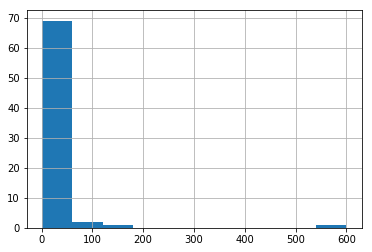

In [66]:
clinical_data['HeadacheD'].hist();

In [67]:
clinical_data['HeadacheD'].describe()

count     73.000000
mean      23.821918
std       72.980466
min        1.000000
25%        5.000000
50%        7.000000
75%       14.000000
max      600.000000
Name: HeadacheD, dtype: float64

Is 600 days a real figure or a typo? I mean, if some patient reported having a headache for two years it would likely by closer to 730. And pressing an additional 0 when entering "60" is not so unlikely..

Dr Rachel agrees that it might be a typo, but it is to be confirmed. Creating a column with corrected data:

In [68]:
clinical_data['headache_days_corrected'] = clinical_data['HeadacheD'].replace({600: 60})
clinical_data['headache_days_corrected'].max()

180.0

Othwerise it looks ok, numeric format, no negative values.

Are headache durations only present for patients with headache?

In [69]:
headache_patients = clinical_data[clinical_data.Headache == True].PatientID

In [70]:
compare_sets(headache_patients, clinical_data[clinical_data.HeadacheD > 0].PatientID)

That is ok - apparently there are no data for this patient when it comes to headache duration. 

### 13. Lethargy

In [71]:
glossary['Lethargy']

'Does the patient experience lethargy?'

In [72]:
clinical_data['Lethargy'].value_counts()

N          71
Y          24
Unknown     3
Name: Lethargy, dtype: int64

In [73]:
clinical_data['Lethargy'] = yes_no_unknown_to_binary(clinical_data['Lethargy'])

### 14. Duration of lethargy

In [74]:
glossary['LethargyD']

'Duration of lethargy (days)'

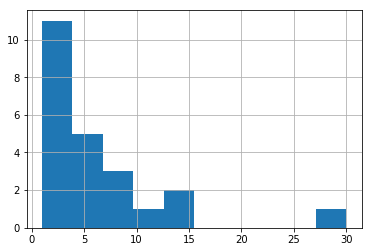

In [75]:
clinical_data['LethargyD'].hist();

### 15. Vomiting

In [76]:
glossary['Vomiting']

'Does the patient suffer vomiting?'

In [77]:
clinical_data['Vomiting'].value_counts()

N          51
Y          44
Unknown     3
Name: Vomiting, dtype: int64

In [78]:
clinical_data['Vomiting'] = yes_no_unknown_to_binary(clinical_data['Vomiting'])

### 16. Duration of vomiting

In [79]:
glossary['VomitingD']

'Duration of vomiting (days)'

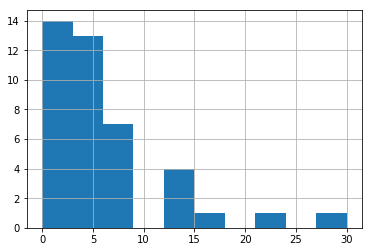

In [80]:
clinical_data['VomitingD'].hist();

In [81]:
compare_sets(
    clinical_data[clinical_data.Vomiting == True].PatientID,
    clinical_data[clinical_data.VomitingD > 0].PatientID
)

Ok!

### 17. Conscious

In [82]:
glossary['Conscious']

'Reduced consciousness'

**Note:** the column name may be misleading!

In [83]:
clinical_data['Conscious'].value_counts()

N    63
Y    34
Name: Conscious, dtype: int64

In [84]:
clinical_data['Conscious'] = yes_no_unknown_to_binary(clinical_data['Conscious'])

### 18. Conscious

In [85]:
glossary['ConsciousD']

'Duration of reduced consciousness (days)'

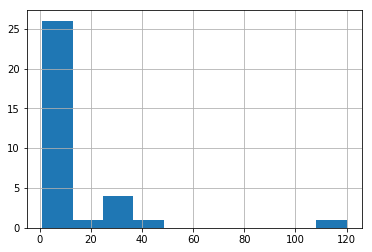

In [86]:
clinical_data['ConsciousD'].hist();

In [87]:
compare_sets(
    clinical_data[clinical_data.Conscious == True].PatientID,
    clinical_data[clinical_data.ConsciousD > 0].PatientID
)

Ok!

### 19. Treatment for TB

In [88]:
glossary['OnTBTreat']

'Is the patient still on TB treatment at the time of admission?'

In [89]:
clinical_data['OnTBTreat'].value_counts()

N    33
Y    10
Name: OnTBTreat, dtype: int64

In [90]:
clinical_data['OnTBTreat'] = yes_no_unknown_to_binary(clinical_data['OnTBTreat'])

Only patients with TB should be on the treatment:

In [91]:
clinical_data[clinical_data['OnTBTreat'] == True].condition.value_counts()

CM     9
TMR    1
Name: condition, dtype: int64

This is surprising... Maybe these are patients who had a history of TB?

In [92]:
clinical_data[clinical_data['OnTBTreat'] == True].PrevTB.value_counts()

True    10
Name: PrevTB, dtype: int64

Yes! This makes sense (the were on treatment at the time of admission).

Are all the noes for patients with history of TB as well?

In [93]:
clinical_data[clinical_data['OnTBTreat'] == False].PrevTB.value_counts()

True    31
Name: PrevTB, dtype: int64

Yes. What about current conditions?

In [94]:
clinical_data[clinical_data['OnTBTreat'] == False].condition.value_counts()

CM     12
HC      7
VM      4
TMR     4
TMD     3
TMS     3
Name: condition, dtype: int64

**Note**: this is interesting that all the patients who are still treated for TB are assigned to the CM group. But such patients form the biggest group among all patients with history of TB, thus it might have been expected.

### 20. Start date of previous TB treatment

In [95]:
glossary['DateTBTreat']

'If yes, when did it start?'

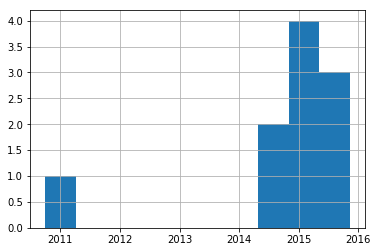

In [96]:
clinical_data['DateTBTreat'].hist();

In [97]:
clinical_data['DateTBTreat'].describe()

count                      10
unique                     10
top       2014-11-11 00:00:00
freq                        1
first     2010-10-01 00:00:00
last      2015-11-10 00:00:00
Name: DateTBTreat, dtype: object

#### Interpeting the glossary

In [98]:
compare_sets(
    clinical_data[clinical_data.OnTBTreat == True].PatientID,
    clinical_data[~clinical_data.DateTBTreat.isnull()].PatientID
)

Data inconsistency?

In [99]:
clinical_data[clinical_data.PatientID == '037.HC'][['condition', 'PrevTB', 'PrevTBTreat', 'OnTBTreat', 'DateTBTreat']]

,condition,PrevTB,PrevTBTreat,OnTBTreat,DateTBTreat
16,HC,True,Y,False,2010-10-01


Maybe. But it may be a matter of description (glossary) interpretation - if the glossary entry was originally placed after the "PrevTBTreat", it would read:

- 'Did the patient receive TB treatment in the past?'
- 'If yes, when did it start?'

which would make sense.

### 21. End date of previous TB treatment

In [100]:
glossary['DateTBTreatStop']

'if not, when did it stop?'

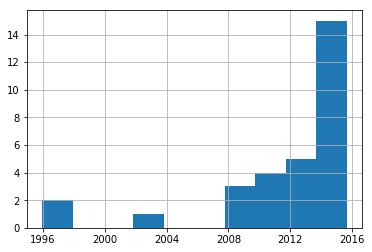

In [101]:
clinical_data['DateTBTreatStop'].hist();

Because the earliest date is older than of the start date:
 - we may have data censoring on both ends - such a wonderful data to experiment with survival models,
 - can we be sure that the column names are not swapped?

Observation - no overlap with start date (expected given the glossary description):

In [102]:
clinical_data[
    (~clinical_data.DateTBTreat.isnull())
    &
    (~clinical_data.DateTBTreatStop.isnull())
].empty

True

#### Minor inconsistencies with treatment status?

In [103]:
compare_sets(
    clinical_data[clinical_data.OnTBTreat == False].PatientID,
    clinical_data[~clinical_data.DateTBTreatStop.isnull()].PatientID
)

The one odd example:

Ok!

In [104]:
columns_of_interest = [
    'PrevTB', 'PrevTBTreat', 'OnTBTreat', 'DateTBTreat', 'DateTBTreatStop',
    'AdmissionDate'
]
clinical_data[clinical_data.PatientID == '224.CM'][columns_of_interest]

,PrevTB,PrevTBTreat,OnTBTreat,DateTBTreat,DateTBTreatStop,AdmissionDate
81,True,Y,True,NaT,2014-09-04,2015-10-05


If the treatment stopped in 2014-09, why was the patient still on treatment when admitted?
One explanation would be that the admission was before this date. But it was not.

Dr Rachel notes that there is an explanation of such discrepancies: the patient may have stopped treatment early; then at the admission the doctor may have placed them back (immediately) on the treatment; this is thought not to be uncommon.

Because it is just a single patient, I think that overall this column is ok.

### 22. Date of lumbar puncture

In [105]:
glossary['DateLP']

'Date of lumbar puncture to sample CSF'

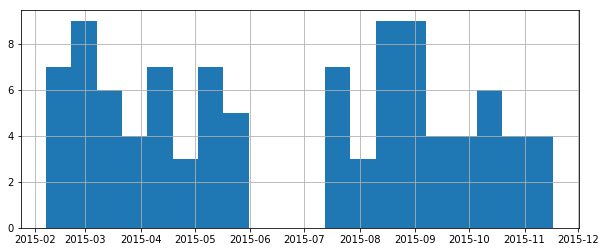

In [106]:
clinical_data['DateLP'].hist(bins=20, figsize=(10, 4));

I expect that there are dates for all patients as all of them had the procedure:

In [107]:
assert not clinical_data['DateLP'].isnull().any()

In [108]:
(clinical_data['DateLP'] >= clinical_data['AdmissionDate']).value_counts()

True     97
False     1
dtype: int64

In [109]:
time_to_puncture = clinical_data['DateLP'] - clinical_data['AdmissionDate']
time_to_puncture.value_counts()

0 days      54
1 days      24
2 days      10
3 days       4
6 days       2
4 days       2
-2 days      1
365 days     1
dtype: int64

In [110]:
outlier_row_id = time_to_puncture.idxmax()
clinical_data.loc[outlier_row_id][['PatientID', 'DateLP','AdmissionDate', 'DateCD4', 'DateAntiTB']]

PatientID                     006.CM
DateLP           2015-02-11 00:00:00
AdmissionDate    2014-02-11 00:00:00
DateCD4          2014-11-07 00:00:00
DateAntiTB       2014-11-11 00:00:00
Name: 1, dtype: object

This is suspicious!

**Update:** this record can be corrected - the electronic record (input date) hints us that the admission date for this patient had a typo.

In [111]:
new_admission_date = clinical_data.loc[outlier_row_id, 'AdmissionDate'].replace(year=2015)
new_admission_date

Timestamp('2015-02-11 00:00:00')

In [112]:
clinical_data.loc[outlier_row_id, 'AdmissionDate'] = new_admission_date

### 23. Appearance of CSF #1

In [113]:
glossary['App1']

'Appearance of the CSF (observation 1)'

In [114]:
clinical_data['App1'].value_counts()

Clear                      93
Mild cloudy/ opalescent     5
Name: App1, dtype: int64

Perfect!

### 24. Appearance of CSF #2

In [115]:
glossary['App2']

'Appearance of the CSF (observation 2)'

In [116]:
clinical_data['App2'].value_counts()

Colourless    93
Yellow         4
Name: App2, dtype: int64

There are different terms than in the first one...

In [117]:
clinical_data[clinical_data.App1 == 'Mild cloudy/ opalescent'][['App1', 'App2']]

,App1,App2
4,Mild cloudy/ opalescent,Colourless
7,Mild cloudy/ opalescent,Colourless
22,Mild cloudy/ opalescent,Colourless
23,Mild cloudy/ opalescent,Colourless
83,Mild cloudy/ opalescent,Colourless


And the values do not correlate. Interesting, though I do not understand this fully:
 - were the two observations performed at different time points, or
 - were the two looking for different things?

**Update:** based on a comment from Dr Rachel, the observations were collected at the same time, but looking at different characteristics: clear/cloudy and color/colorless respectively.

### 25. Red blood cells count

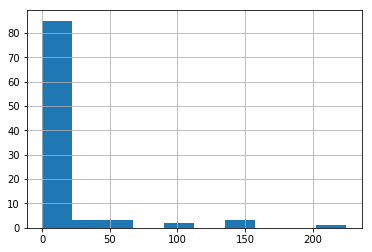

In [118]:
clinical_data['RCC'].hist();

In [119]:
clinical_data['RCC'].describe()

count     97.000000
mean      13.134021
std       36.968069
min        0.000000
25%        0.000000
50%        0.000000
75%        5.000000
max      225.000000
Name: RCC, dtype: float64

How was RCC measured? In CSF? That would seem likely given a lot of zeros!

If this is the case, there should be a few healthy controls with RCC > 0:

In [120]:
clinical_data[clinical_data.RCC > 0].condition.value_counts()

CM     11
TMD    10
HC      4
TMR     4
TMS     3
VM      2
BM      1
Name: condition, dtype: int64

### 26. White blood cells count

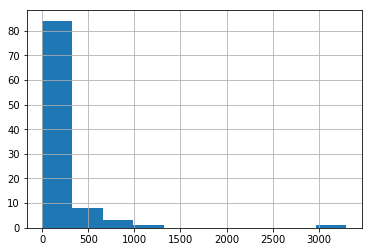

In [121]:
clinical_data['WCC'].hist();

In [122]:
clinical_data[clinical_data.WCC > 0].condition.value_counts()

CM     19
TMD    19
HC     10
TMR    10
VM      8
TMS     6
BM      2
Name: condition, dtype: int64

### 27. Percent of neutrophils among WBC

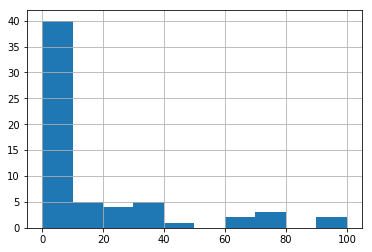

In [123]:
clinical_data['%Neutro'].hist();

The range is 0-100 - ok.

The spike at zero could be due to many samples having zero WCC. Is it?

In [124]:
zero_percent = clinical_data[clinical_data['%Neutro'] == 0]
zero_percent[zero_percent.WCC == 0].empty

True

No, it is not.

Sanity check: %Neutro > 0 only if WCC > 0?

In [125]:
(clinical_data[clinical_data['%Neutro'] > 0].WCC > 0).all()

True

### 28. Percent of lymphocytes among WBC

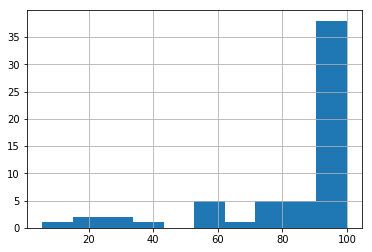

In [126]:
clinical_data['%Lympho'].hist();

Range is ok. %Lympho > 0 only if WCC > 0?

In [127]:
(clinical_data[clinical_data['%Lympho'] > 0].WCC > 0).all()

True

Great!

### 29. Protein in CSF

In [128]:
glossary['Protein']

'Total CSF protein'

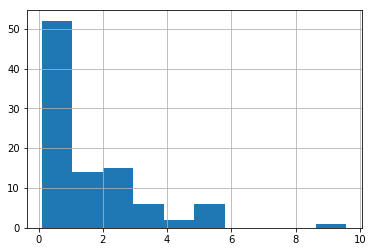

In [129]:
clinical_data['Protein'].hist();

Protein >= 0 → ok.
No other sanity checks if could think of.

Only one missing value:

In [130]:
clinical_data['Protein'].isnull().sum()

2

### 30. Glucose in CSF

In [131]:
glossary['CSFGlucose']

'Level of glucose in CSF'

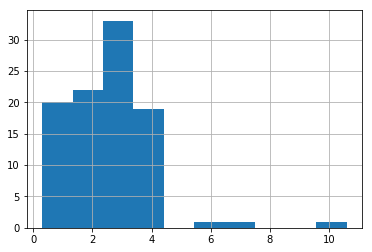

In [132]:
clinical_data['CSFGlucose'].hist();

In [133]:
clinical_data['CSFGlucose'].isnull().sum()

1

### 31. Was anti-TB treatment started (this admission)?

In [134]:
clinical_data['AntiTB'].value_counts()

Y    50
N    48
Name: AntiTB, dtype: int64

In [135]:
clinical_data[clinical_data['AntiTB'] == 'Y'].condition.value_counts()

TMD    19
CM     15
TMR    10
TMS     6
Name: condition, dtype: int64

Given the Monday discussion I understand that the treatment may be decided upon before the final diagnosis is made, thus I just assume that the classes are ok.

In [136]:
clinical_data['AntiTB'] = yes_no_unknown_to_binary(clinical_data['AntiTB'])

### 32. The start date of anti-TB treatment (this admission)

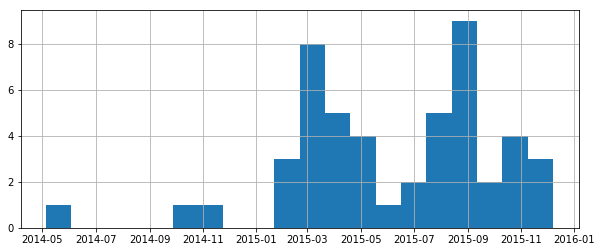

In [137]:
clinical_data['DateAntiTB'].hist(bins=20, figsize=(10, 4));

All who have a start date should also be marked as having the treatment:

In [138]:
assert clinical_data[~clinical_data.DateAntiTB.isnull()].AntiTB.all()

### 33. Was steroid started (this admission)?

In [139]:
glossary['SteroidsStarted']

'Was steroid started in this admission? (Note: steroid is used to reduce inflammation but it changes transcriptional, protein and metabolomic responses)'

In [140]:
clinical_data['SteroidsStarted'].value_counts()

N    63
Y    35
Name: SteroidsStarted, dtype: int64

In [141]:
clinical_data['SteroidsStarted'] = yes_no_unknown_to_binary(clinical_data['SteroidsStarted'])

### 34. The date of starting steroid (this admission)

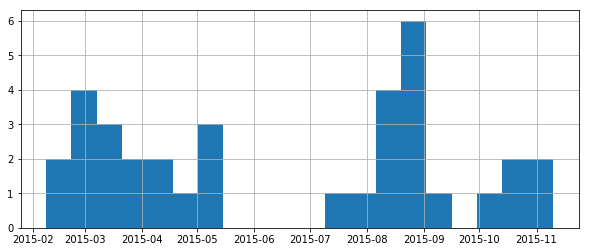

In [142]:
clinical_data['SteroidDate'].hist(bins=20, figsize=(10, 4));

All who have a start date should also be marked as having the treatment:

In [143]:
assert clinical_data[~clinical_data.SteroidDate.isnull()].SteroidsStarted.all()

### 35. Type of steroid

In [144]:
glossary['SteroidType']

'Which steroid did the patient receive?'

In [145]:
clinical_data['SteroidType'].value_counts()

Prednisone       32
Dexamethasone     3
Name: SteroidType, dtype: int64

Data for all the 34 - ok!

### 36. Death

In [146]:
glossary['Death']

'Did the patient survive during the course of the study?'

In [147]:
clinical_data['Death'].value_counts()

Alive    75
Death    23
Name: Death, dtype: int64

In [148]:
clinical_data['Death'] = clinical_data['Death'].replace({'Alive': False, 'Death': True})

It might be good to know when was the end of the study to know the right censoring horizon.

### 37. Date of death

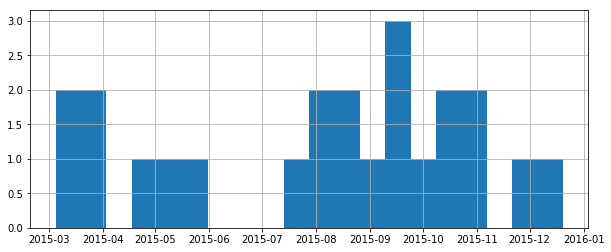

In [149]:
clinical_data['DateDeath'].hist(bins=20, figsize=(10, 4));

In [150]:
assert clinical_data[~clinical_data.DateDeath.isnull()].Death.all()

One could envision many sanity checks for this:

In [151]:
for date_column in ['SteroidDate', 'DateAntiTB', 'DateLP', 'AdmissionDate']: 
    assert not (clinical_data[date_column] > clinical_data['DateDeath']).any()

### 38. CD4 test date

In [152]:
glossary['DateCD4']

'The date when CD4 count was done (Note: patient might have been tested in local clinics before being referred to the study hospital)'

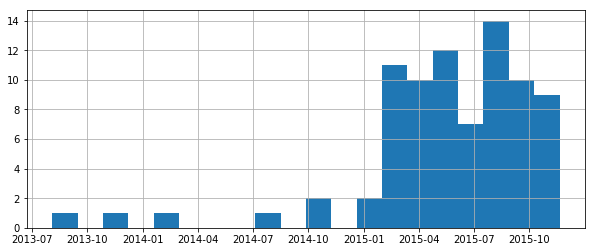

In [153]:
clinical_data.DateCD4.hist(bins=20, figsize=(10, 4));

In [154]:
(clinical_data.DateCD4 >= clinical_data.AdmissionDate).sum()

51

In [155]:
(clinical_data.DateCD4 < clinical_data.AdmissionDate).sum()

30

A quick note: about a third of the CD4 tests was performed before the current admission; 
it is plausible as the test might have been done immediately after the HIV diagnosis or around the time when someone was suspected to have HIV.

The glossary entry reaffirms that this is ok.

In [156]:
compare_sets(
    clinical_data[~clinical_data.CD4.isnull()].PatientID,
    clinical_data[~clinical_data.DateCD4.isnull()].PatientID
)

### 39. Gender

In [157]:
clinical_data['Sex'].value_counts()

M    50
F    48
Name: Sex, dtype: int64

Perfect!

## Variable exploration summary

There are many variables which are by definition dependent one on another. These are:

In [158]:
# this dictionary was organised in shuch a way that the column with
# the most data is the key (on the left side, preferring the re-formatted ones)
relations = {
    'PrevTB': [
        'PrevTBForm', 'PrevTBTreat',
        # to be confirmed
        'OnTBTreat', 'DateTBTreat', 'DateTBTreatStop',
        # addded columns
        'was_previous_tb_pulmonary', 'was_previous_tb_extrapulmonary',
        'previous_tb_treatment'
    ],
    'HIVResult': ['CD4', 'ARV', 'UnARV'],
    'Headache': ['HeadacheD', 'headache_days_corrected'],
    'Lethargy': ['LethargyD'],
    'Vomiting': ['VomitingD'],
    'Conscious': ['ConsciousD'],
    # OnTBTreat not only defines the presence of the dates, but also which date was recorded!
    'OnTBTreat': ['DateTBTreat', 'DateTBTreatStop'],
    # These dates are mutually exclusive:
    'DateTBTreat': ['DateTBTreatStop'],
    'WCC': ['%Neutro', '%Lympho'],
    'AntiTB': ['DateAntiTB'],
    'SteroidsStarted': ['SteroidDate', 'SteroidType'],
    'Death': ['DateDeath'],
    'CD4': ['DateCD4']
}

## Data completeness

### Patient-wise

Are there any patients for whom there is too little data in general?

Exclude the dependent variables so that we don't have unequal weights of missing values just because there were some variables measured only in a subset of patients:

In [159]:
key_variables = set(clinical_data.columns) - {e for l in relations.values() for e in l}
len(key_variables)

22

In [160]:
subset = clinical_data[key_variables].set_index('PatientID')
missing_data = (100 * subset.isnull().sum(axis=1) / len(subset.columns))
missing_data = missing_data[missing_data > 0]

In [161]:
missing_data.to_frame()

,0
PatientID,
013.CM,4.761905
015.CM,4.761905
016.CM,4.761905
030.TMR,14.285714
049.TMS,19.047619
...,...
080.HC,4.761905
109.HC,4.761905
224.CM,9.523810


Up to 20% of missing "key" variables per patient (key variable defined as not being dependent - due to the data collection procedure - on other variables).

It should not be a big problem.

We may want to exclude the patient with 20% of missing data (also, see the note on PLS tolerance to missing values below). I will keep all the patients for now, because I may be able to fill the missing values for some of the variables and it may lower the percentage to more acceptable level.

### Variable-wise

In [162]:
missing_percent = (100 * subset.isnull().sum(axis=0) / len(subset))
missing = missing_percent[missing_percent != 0]
missing.sort_values().to_frame()

,0
App2,1.020408
WCC,1.020408
CSFGlucose,1.020408
RCC,1.020408
Conscious,1.020408
Protein,2.040816
Headache,3.061224
Vomiting,3.061224
PrevTB,3.061224
Lethargy,3.061224


Up to 3.2% of missing data on the selected variables - good enough!

### Overall

In [163]:
ratio_missing = subset.isnull().sum(axis=1).sum() / (len(subset) * len(subset.columns))
f'{100 * ratio_missing:.2f}%'

'0.92%'

(S. Wold et. al, 2001) states that PLS can handle up to 10-20% of missing data for dataset with 20 observations / 20 variables if the values are not missing in systematic pattern (thus the exclusion of non-key columns) and that the tolerance to missing values increases with the increase in dataset size.

Thus there should be no problem with 1% of missing data.

Why is 20/20 anyhow relevant to this dataset?
- there are 22 clinical variables; even though these will be changed (admission date or date of birth does not really count, but I will get age/ survival out of these), there will be ~20 major variables in the end
- the subgroups (by condition) if analyzed separately have about 20 observations

In [164]:
clinical_data.set_index('PatientID').to_csv(clean_clinical_path)